In [16]:
# Install pyparsing
!pip install pyparsing



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
# Import necessary libraries
from pyparsing import Word, alphas, nums, oneOf, QuotedString, Group, Forward, infixNotation, opAssoc

# Define Node class for AST structure
class Node:
    def __init__(self, type, left=None, right=None, value=None):
        self.type = type  # Type of the node: "operator" or "operand"
        self.left = left  # Left child node
        self.right = right  # Right child node
        self.value = value  # Value of the node for operands or operators

    def __repr__(self):
        if self.type == "operator":
            return f"({self.left} {self.value} {self.right})"
        else:
            return str(self.value)


In [6]:
# Define create_rule function to parse rule strings and create AST
def create_rule(rule_string):
    # Define parsing components
    identifier = Word(alphas)  # To capture words like 'age' and 'department'
    number = Word(nums)  # To capture numeric values
    string_literal = QuotedString("'")  # For string values like 'Sales' or 'Marketing'
    operand = identifier | number | string_literal  # Operand can be an identifier, number, or string

    # Define comparison and logical operators
    comparison_op = oneOf("> < =")  # Comparison operators
    logical_op = oneOf("AND OR")  # Logical operators for combining conditions

    # Recursive definition for expressions
    expr = Forward()
    comparison = Group(operand + comparison_op + operand).setParseAction(
        lambda t: Node("operand", None, None, t.asList())
    )

    # Logical operators in infix notation
    expr <<= infixNotation(comparison, [
        ("AND", 2, opAssoc.LEFT, lambda t: Node("operator", t[0][0], t[0][2], "AND")),
        ("OR", 2, opAssoc.LEFT, lambda t: Node("operator", t[0][0], t[0][2], "OR"))
    ])

    # Parse the rule string
    try:
        parsed = expr.parseString(rule_string, parseAll=True)
        return parsed[0]  # Root node of AST
    except Exception as e:
        print("Error parsing rule:", e)
        return None


In [7]:
# Function to combine multiple ASTs with a logical operator
def combine_rules(rules, operator="AND"):
    if not rules:
        return None
    if len(rules) == 1:
        return rules[0]

    combined_ast = rules[0]
    for rule_ast in rules[1:]:
        combined_ast = Node("operator", combined_ast, rule_ast, operator)
    return combined_ast


In [8]:
# Function to evaluate an AST against user data
def evaluate_rule(node, data):
    if node.type == "operand":
        attr, op, val = node.value
        attr_value = data.get(attr)

        # Comparison operations
        if op == ">":
            return attr_value > float(val)
        elif op == "<":
            return attr_value < float(val)
        elif op == "=":
            return str(attr_value) == str(val)
    elif node.type == "operator":
        left_eval = evaluate_rule(node.left, data)
        right_eval = evaluate_rule(node.right, data)

        # Logical operations
        if node.value == "AND":
            return left_eval and right_eval
        elif node.value == "OR":
            return left_eval or right_eval
    return False


In [9]:
# Define sample rule strings
rule1_string = "((age > 30 AND department = 'Sales') OR (age < 25 AND department = 'Marketing')) AND (salary > 50000 OR experience > 5)"
rule2_string = "((age > 30 AND department = 'Marketing')) AND (salary > 20000 OR experience > 5)"

# Create ASTs for sample rules
rule1_ast = create_rule(rule1_string)
rule2_ast = create_rule(rule2_string)

# Combine rules
combined_ast = combine_rules([rule1_ast, rule2_ast], operator="AND")

# Sample user data for evaluation
sample_data1 = {"age": 35, "department": "Sales", "salary": 60000, "experience": 3}
sample_data2 = {"age": 23, "department": "Marketing", "salary": 25000, "experience": 6}

# Test evaluations
print("Rule 1 AST:", rule1_ast)
print("Rule 2 AST:", rule2_ast)
print("Combined AST:", combined_ast)



Rule 1 AST: ((([['age', '>', '30']] AND [['department', '=', 'Sales']]) OR ([['age', '<', '25']] AND [['department', '=', 'Marketing']])) AND ([['salary', '>', '50000']] OR [['experience', '>', '5']]))
Rule 2 AST: (([['age', '>', '30']] AND [['department', '=', 'Marketing']]) AND ([['salary', '>', '20000']] OR [['experience', '>', '5']]))
Combined AST: (((([['age', '>', '30']] AND [['department', '=', 'Sales']]) OR ([['age', '<', '25']] AND [['department', '=', 'Marketing']])) AND ([['salary', '>', '50000']] OR [['experience', '>', '5']])) AND (([['age', '>', '30']] AND [['department', '=', 'Marketing']]) AND ([['salary', '>', '20000']] OR [['experience', '>', '5']])))


In [10]:
api_key = "e7b7b55f805ebeacb1929b9ba24c46e3"


In [11]:
import requests
import time

# List of metro cities in India
cities = ["Delhi", "Mumbai", "Chennai", "Bangalore", "Kolkata", "Hyderabad"]

# Function to fetch weather data for each city
def fetch_weather_data(api_key, city):
    url = f"http://api.openweathermap.org/data/2.5/weather?q={city}&appid={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        weather_info = {
            "city": city,
            "main": data["weather"][0]["main"],
            "temp": data["main"]["temp"] - 273.15,  # Convert from Kelvin to Celsius
            "feels_like": data["main"]["feels_like"] - 273.15,  # Convert from Kelvin to Celsius
            "dt": data["dt"]
        }
        return weather_info
    else:
        print(f"Failed to retrieve data for {city}")
        return None


In [12]:
# Dictionary to store weather data history
weather_data_history = {city: [] for city in cities}

# Function to retrieve data for all cities at intervals
def collect_weather_data(api_key, interval=300):
    while True:
        for city in cities:
            weather_info = fetch_weather_data(api_key, city)
            if weather_info:
                weather_data_history[city].append(weather_info)
        print("Data retrieved for all cities. Sleeping...")
        time.sleep(interval)  # Wait for the specified interval before the next fetch


In [13]:
from datetime import datetime
from collections import Counter

# Helper to convert timestamps to date
def to_date(timestamp):
    return datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')

# Function to compute daily summary for each city
def daily_summary(city):
    daily_data = {}
    for entry in weather_data_history[city]:
        date = to_date(entry["dt"])
        if date not in daily_data:
            daily_data[date] = {"temp": [], "conditions": []}
        daily_data[date]["temp"].append(entry["temp"])
        daily_data[date]["conditions"].append(entry["main"])

    daily_summary = {}
    for date, values in daily_data.items():
        temps = values["temp"]
        conditions = values["conditions"]
        daily_summary[date] = {
            "avg_temp": sum(temps) / len(temps),
            "max_temp": max(temps),
            "min_temp": min(temps),
            "dominant_condition": Counter(conditions).most_common(1)[0][0]
        }
    return daily_summary


In [14]:
# Threshold for triggering alerts
temp_threshold = 35  # Celsius

# Function to check for threshold breaches
def check_thresholds(city):
    recent_data = weather_data_history[city][-2:]  # Last two updates for the city
    if len(recent_data) < 2:
        return
    # Check for consecutive temperature breaches
    if all(data["temp"] > temp_threshold for data in recent_data):
        print(f"Alert! {city} temperature exceeded {temp_threshold}°C for two consecutive updates.")


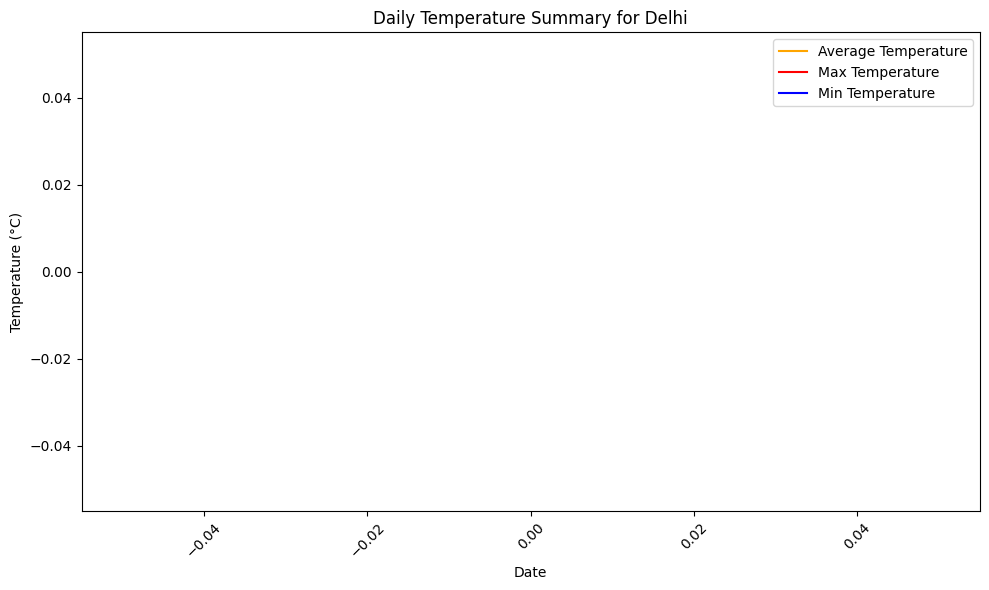

In [15]:
import matplotlib.pyplot as plt

# Plot function for visualizing daily temperature summary
def plot_daily_summary(city, daily_summary_data):
    dates = list(daily_summary_data.keys())
    avg_temps = [data["avg_temp"] for data in daily_summary_data.values()]
    max_temps = [data["max_temp"] for data in daily_summary_data.values()]
    min_temps = [data["min_temp"] for data in daily_summary_data.values()]

    plt.figure(figsize=(10, 6))
    plt.plot(dates, avg_temps, label='Average Temperature', color='orange')
    plt.plot(dates, max_temps, label='Max Temperature', color='red')
    plt.plot(dates, min_temps, label='Min Temperature', color='blue')
    plt.xlabel("Date")
    plt.ylabel("Temperature (°C)")
    plt.title(f"Daily Temperature Summary for {city}")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Usage example:
# Calculate daily summary for a city (e.g., "Delhi")
delhi_summary = daily_summary("Delhi")
plot_daily_summary("Delhi", delhi_summary)
